### Importation 

In [1]:
import sys
sys.path.append('/volatile/Lena/Codes/Modèles/fastmri_tf_vs_torch/fastmri_compare/')
import time

In [2]:
# Time 
startTimer = time.time()

# Library 
import torch
from matplotlib import pyplot as plt 
from fastmri.models.unet import Unet
from fastmri.data.subsample import create_mask_for_mask_type

# Own function 
from unet_C.unet_torch_trainning_script import filename_to_image_and_kspace, get_zerofilled

endTimerImport = time.time()

### Load model : Unet from fastmri.models.unet written in PyTorch

In [3]:
model = Unet(in_chans=1, out_chans=1, num_pool_layers=4)

Recover the model recorded by us during a training session on JZ with more data. 
Put this model in evaluation mode to use it and not train it again. 

In [4]:
model.load_state_dict(torch.load("/volatile/Lena/Codes/fastmri_unet_model.pth"))
# model.load_state_dict(torch.load("/volatile/Lena/Codes/Modèles/fastmri_tf_vs_torch/examples/fastmri_unet_model.pth"))
model.eval()

Unet(
  (down_sample_layers): ModuleList(
    (0): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dropout2d(p=0.0, inplace=False)
        (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (6): LeakyReLU(negative_slope=0.2, inplace=True)
        (7): Dropout2d(p=0.0, inplace=False)
      )
    )
    (1): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dropout2

### Import and pre-process data on which to apply the model.

 Function "filename_to_image_and_kspace" takes an MRI path as argument and returns the kspace and image. As the data is in Multi coil, this function also uses VCR to transform my data into Single coil. 

In [5]:
filepath = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/dataset/file_brain_AXT1POST_201_6002780.h5"
image, kspace = filename_to_image_and_kspace(filepath)

### Mask creation 

The "get_zerofilled" function takes as arguments the kspace, the type of mask you want to create (random ...), the center_fractions and the accelerations. 
It creates a different mask for each batch and applies it to the kspace of the batch involved. This is the "masked_kspace". "get_zerofilled" returns the "zero_filled" image of this masked_kspace.

In [6]:
def get_zerofilled( 
        kspace,
        mask_type = "random", 
        center_fractions = [0.08],
        accelerations = [4],
        ):
    
    mask_func = create_mask_for_mask_type(mask_type, center_fractions, accelerations)

    if len(kspace.shape) == 4 :
        kspace = kspace.unsqueeze(-1)
    
    zero_filled_list = []
    for batch in range (kspace.shape[0]) :
        mask, _ = mask_func(kspace.shape)
        masked_kspace = kspace[batch] * mask
        zero_filled =torch.fft.ifftn(masked_kspace)
        zero_filled_list.append(zero_filled)

    zero_filled = torch.cat(zero_filled_list)
    zero_filled = zero_filled.squeeze(-1)

    return zero_filled

In [7]:
zero_filled = get_zerofilled(kspace)
zero_filled = torch.abs(zero_filled)

Visualisation of all batch from zero_filled

torch.Size([16, 1, 640, 320])


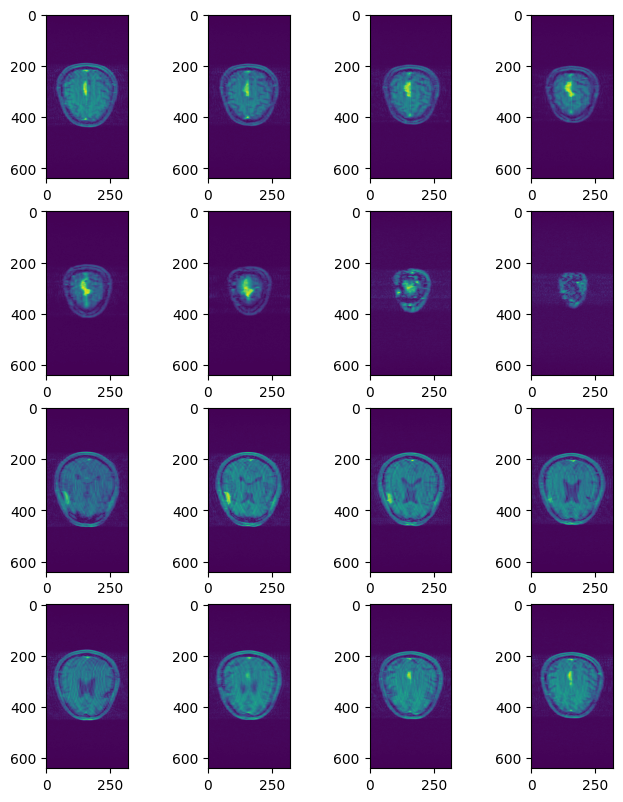

In [8]:
print(zero_filled.shape)
plt.figure(figsize=(8,20))
for i in range(zero_filled.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(zero_filled[i,0,:,:])


### Prediction

In [9]:
with torch.no_grad():
    output = model(zero_filled)

torch.Size([16, 1, 640, 320])


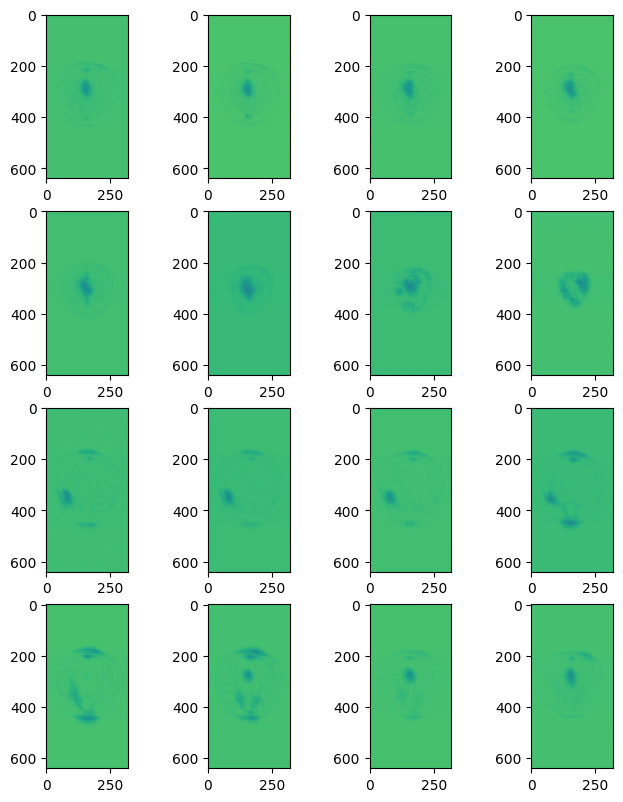

In [10]:
print(output.shape)
plt.figure(figsize=(8,20))
for i in range(output.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(output[i,0,:,:])


In [11]:
endTimer = time.time()

In [12]:
print("The import lasted",round(endTimerImport - startTimer,2) ,"sec and the script lasted ", round(endTimer - startTimer, 2 )," sec")

The import lasted 2.18 sec and the script lasted  13.84  sec
